# Implement different edge detection algorithms: Sobel, Laplacian, Canny

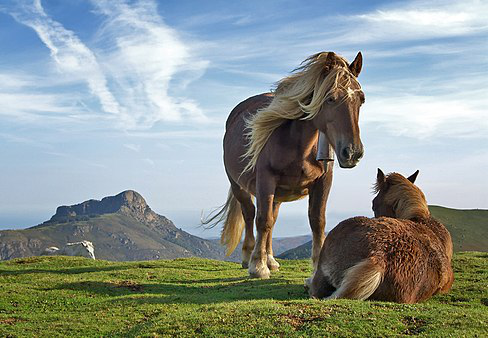

In [1]:
from PIL import Image
import scipy.signal as sgn
import numpy as np

# Read the image
from PIL import Image
image=Image.open('wiki-2008.jpg')
gray_image=image.convert('L')
img_arr=np.array(gray_image)
image

## Sobel  edge detection

In [2]:
def detect_edge_with_filter(im_arr, filters, direction=2):
    """
        im_arr: numpy array of the image
        filters: [filter_x,filter_y] respectively are the filters in x and y direction
        direction:  0: x-direction
                    1: y-direction
                    2: x and y direction
        Return: edge_intensity matrix (uint8 numpy array)
                gradient_direction matrix (direction of most change in intensity of each point), 
                    perpendicular with direction of the edge. Only return when direction = 2
    """
    edge_intensity = None
    gradient_direction = None
    if direction == 0:
        edgex = sgn.correlate(im_arr, filters[0])
        edge_intensity = np.abs(edgex)  # get the magnitude of the intensity(absolute value)
    elif direction == 1:
        edgey = sgn.correlate(im_arr, filters[1])
        edge_intensity = np.abs(edgey)  # get the magnitude of the intensity(absolute value)
    else:
        edgex = sgn.correlate(im_arr, filters[0])
        edgey = sgn.correlate(im_arr, filters[1])
        edge_intensity = np.sqrt(edgex**2+edgey**2)
        gradient_direction = np.arctan2(edgey, edgex)

    edge_intensity = np.uint8(edge_intensity)

    return (edge_intensity, gradient_direction)

In [3]:
def detectBySobel(im_arr, direction=2):
    """ Edge detection with Sobel filter 
        Arguments and return values similar to detect_edge_with_filter() function
    """
    # Sobel filter in X and Y direction
    Sobel_filter = 1/8*np.array([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                                [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    return detect_edge_with_filter(im_arr, Sobel_filter, direction)


def detectByPrewitt(im_arr, direction=2):
    """ Edge detection with Prewitt filter 
        Arguments and return values similar to detect_edge_with_filter() function
    """
    # Prewitt filter in X and Y direction
    Prewitt_filter = 1/6 * np.array([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
                                    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]])
    return detect_edge_with_filter(im_arr, Prewitt_filter, direction)

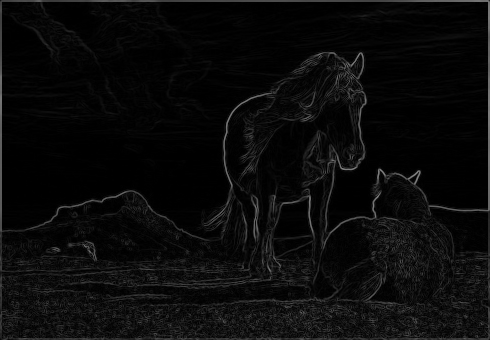

In [4]:
sobel,_ = detectBySobel(img_arr)
Image.fromarray(sobel)

## Laplacian Edge detection

In [5]:
def Laplacian_kernel(ksize=5, sigma=1):
    """ Generate Laplacian kernel
        ksize: kernel size
        sigma: standard deviation

        Formula: Laplacian(x,y) = d2(gauss(x,y))/dx2 + d2(gauss(x,y))/dy2
                        = 1/(2*pi*sigma^2) * exp(-(x^2+y^2)/(2*sigma^2)) * (x^2+y^2-2*sigma^2)/sigma^4
        
        Return: Laplacian kernel numpy array
    """
    half_size = ksize//2
    # 2 array size (ksize,ksize) have the value of corresponding x and y
    # x_values[i,j]=i-half_size, y_values[i,j]=j-half_size
    x_values, y_values = np.mgrid[-half_size: half_size + 1, -half_size: half_size+1]
    lap = np.exp(-(x_values**2+y_values**2)/2*sigma**2) 
    lap = lap * (x_values**2+y_values**2-2**sigma**2)/sigma**4
    lap /= (2*np.pi*sigma**2)
    return lap

def detectByLaplacian(img_arr, ksize=5, sigma=1):
    """ Edge detection with Prewitt filter 
        img_array: numpy array of the image
        ksize: kernel size
        sigma: standard deviation

        Return: edge array
    """
    kernel = Laplacian_kernel(ksize, sigma)
    # image correlate with Laplacian filter
    laplacian = sgn.correlate(img_arr, kernel)

    # Find zero-crossing point
    # using filter [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
    # zero-crossing points will have high value
    laplacian[laplacian > 0] = 1
    laplacian[laplacian < 0] = -1
    zero_crossing_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    edge = sgn.correlate(laplacian, zero_crossing_filter)

    # Edges is point with high absolute value
    edge = np.abs(edge)

    # Transform array to uint8 (0->255) array
    edge /= (edge.max()/255)
    edge = edge.astype(np.uint8)

    return edge

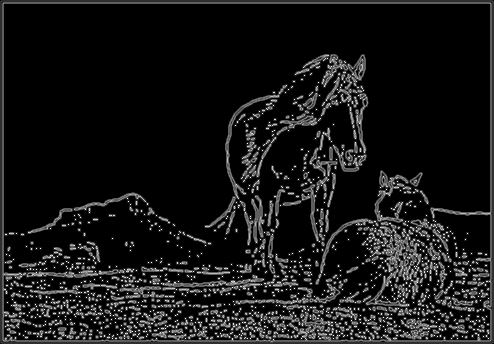

In [6]:
lap= detectByLaplacian(img_arr)
Image.fromarray(lap)

## Canny Edge detection

In [7]:
def Gaussian_kernel(ksize=5, sigma=1):
    """ Generate Laplacian kernel
        ksize: kernel size
        sigma: standard deviation

        Formula: Gaussian(x,y) = 1/(2*pi*sigma^2) * exp(-(x^2+y^2)/(2*sigma^2))
        
        Return: Laplacian kernel numpy array
    """
    half_size=ksize//2
    # 2 array size (ksize,ksize) have the value of corresponding x and y
    # x_values[i,j]=i-half_size, y_values[i,j]=j-half_size
    x_values, y_values = np.mgrid[-half_size: half_size+1, -half_size: half_size+1]
    gauss=np.exp(-(x_values**2+y_values**2)/2*sigma**2)
    gauss /= (2*np.pi*sigma**2)
    gauss/=gauss.sum()
    return gauss

def Gaussian_noise_reduction(img_arr, ksize=5, sigma=1):
    """ Reduce noise by using Gaussian filter
        ksize: kernel size
        sigma: standard deviation
    """
    kernel = Gaussian_kernel(ksize, sigma)
    result = sgn.correlate(img_arr, kernel)
    result = result.astype(np.uint8)
    return result

def non_max_suppression(edge_intensity, gradient_direction):
    """ Non max suppression algorithm for Canny edge detection
        THINGING EDGES by only keep points with highest intensity along edges

        edge_intensity: edge intensity value (gradient value)
        gradient_direction: direction that gradient value change the most

        Return: edge intensity array with THIN EDGES
    """
    # Transform gradient direction angles [-pi,pi] -> [-pi/2,pi/2] (keep the same tan value)
    gradient_direction[gradient_direction < -np.pi/2] += np.pi
    gradient_direction[gradient_direction > np.pi/2] -= np.pi

    result = np.zeros_like(edge_intensity)
    # 4 directions to take into account: 90, 45, 0, -45 degree
    # Gradient direction angle threshold to these directions
    angle_threshold = [-1/2*np.pi, -3/4*np.pi, -1/8*np.pi, 1/8*np.pi, 3/8*np.pi, 1/2*np.pi]
    # Added values in the index of adjacent point correspond to these angle thresholds
    adj_delta = [(1, 0), (1, 1), (0, 1), (-1, 1), (1, 0)]

    for i in range(1, edge_intensity.shape[0]-1):
        for j in range(1, edge_intensity.shape[1]-1):
            adj1 = adj2 = 0
            for k in range(len(angle_threshold)-1):
                # if gradient direction angle belong to range between 2 thresholds
                # then calculate the adjacents points
                if (angle_threshold[k] <= gradient_direction[i, j]) and (gradient_direction[i, j] < angle_threshold[k+1]):
                    adj1 = edge_intensity[i+adj_delta[k][0], j+adj_delta[k][1]]
                    adj2 = edge_intensity[i-adj_delta[k][0], j-adj_delta[k][1]]
                    break
            # If considering point have higher value than it's adjacent points
            # then keep it's value, otherwise set value to 0
            if (edge_intensity[i, j] >= adj1) and (edge_intensity[i, j] >= adj2):
                result[i, j] = edge_intensity[i, j]
    
    return result

def hysteresis(img_arr, high_threshold_ratio,low_threshold_ratio):
    """ Hysteresis in Canny edge detection
        Using 2 thresholds: 
        high threshold to find strong edge points
        low threshold to find weak edge points
        If a weak edge point adjacent to a strong edge point, then it is a strong edge point

        high_threshold_ratio: high_threshold / max(img_arr) (relative to the highest intensity value)
        low_theshold_ratio: high_theshold / low_theshold (relative to high threshold)

        Return: Edge numpy array
    """
    # Calculate high and low thresholds
    high_threshold=img_arr.max()*high_threshold_ratio
    low_threshold=high_threshold*low_threshold_ratio

    # Positions with strong edge points
    strong = img_arr>=high_threshold
    # Positions with weak edge points
    weak=(img_arr>=low_threshold) & (img_arr<high_threshold)

    # Position with weak edge points and have an adjacent strong edge point
    adj_mask=np.array([[1,1,1],[1,0,1],[1,1,1]])
    weak_adjacent_strong = weak & (sgn.correlate(strong,adj_mask,mode='same')>0)
    
    result=np.zeros_like(img_arr)
    # Only strong edge points and weak edge points is considered edge points
    result[strong]=255
    result[weak_adjacent_strong]=255

    return result


def detectByCanny(img_arr, high_threshold_ratio = 0.3, low_threshold_ratio = 0.05, ksize=3,sigma=1):
    """ Canny edge detection
        high_threshold_ratio: high_threshold / max(img_arr)
        low_theshold_ratio: high_theshold / low_theshold
        ksize: Gaussian kernel size to reduce noise
        sigma: Gaussian kernel sigma to reduce noise

        Return: Edge numpy array
    """
    # 4 steps in Canny edge detection algorithm
    noise_reduced = Gaussian_noise_reduction(img_arr,ksize,sigma)
    edge_intensity, gradient_direction = detectBySobel(noise_reduced)
    thin_edge = non_max_suppression(edge_intensity,gradient_direction)
    result = hysteresis(thin_edge, high_threshold_ratio,low_threshold_ratio)

    return result

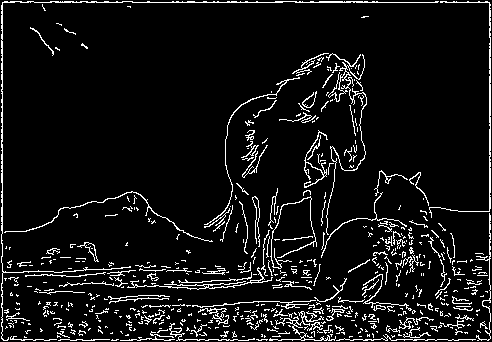

In [8]:
canny= detectByCanny(img_arr, 0.2,0.03)
Image.fromarray(canny)

## Comparision

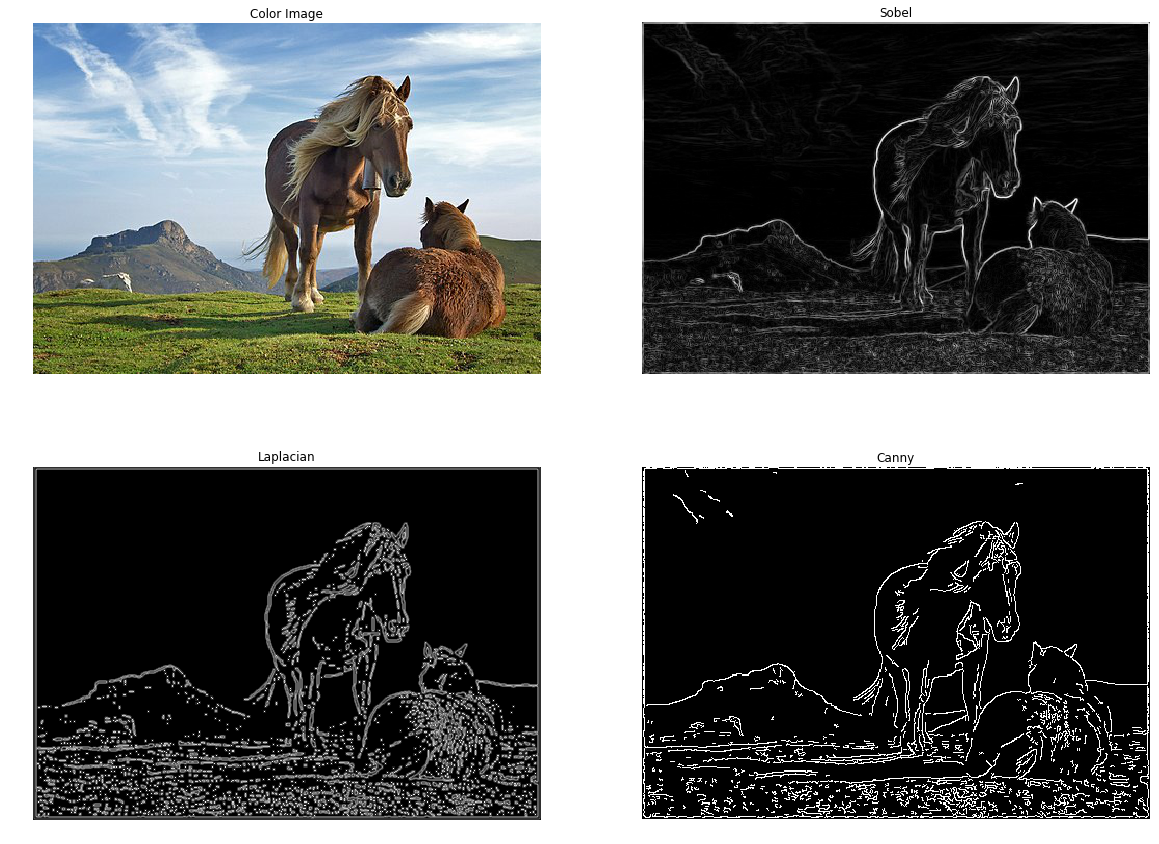

In [10]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 15))

img = Image.open('wiki-2008.jpg')
color_arr=np.array(img)

fig.add_subplot(2, 2, 1)
plt.imshow(color_arr,cmap='gray')
plt.axis('off')
plt.gca().set_title('Color Image')


gray_img=img.convert('L')
img_arr = np.array(gray_img)

fig.add_subplot(2, 2, 2)
sobel, _ = detectBySobel(img_arr)
plt.imshow(sobel,cmap='gray')
plt.axis('off')
plt.gca().set_title('Sobel')

fig.add_subplot(2, 2, 3)
lap= detectByLaplacian(img_arr)
plt.imshow(lap,cmap='gray')
plt.axis('off')
plt.gca().set_title('Laplacian')

fig.add_subplot(2, 2, 4)
canny= detectByCanny(img_arr, 0.2,0.03)
plt.imshow(canny,cmap='gray')
plt.axis('off')
plt.gca().set_title('Canny')

plt.show()